<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/mosaicml/MosaicML_Composer_and_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{mosaicml} -->

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<img src="https://raw.githubusercontent.com/mosaicml/composer/dev/docs/source/_static/images/header_dark.svg" width="400" alt="mosaicml" />

<!--- @wandbcode{mosaicml} -->

# Running fast with MosaicML Composer and Weight and Biases

[MosaicML Composer](https://docs.mosaicml.com) is a library for training neural networks better, faster, and cheaper. It contains many state-of-the-art methods for accelerating neural network training and improving generalization, along with an optional Trainer API that makes composing many different enhancements easy.

Coupled with [Weights & Biases integration](https://docs.mosaicml.com/en/v0.5.0/trainer/logging.html), you can quickly train and monitor models for full traceability and reproducibility with only 2 extra lines of code:

```python
from composer.loggers import WandBLogger
wandb_logger = WandBLogger()
```

W&B integration with Composer can automatically:
* log your configuration parameters
* log your losses and metrics
* log gradients and parameter distributions
* log your model
* keep track of your code
* log your system metrics (GPU, CPU, memory, temperature, etc)

### 🛠️ Installation and set-up

We need to install the following libraries:
* [mosaicml-composer](https://docs.mosaicml.com/en/v0.5.0/getting_started/installation.html) to set up and train our models
* [wandb](https://docs.wandb.ai/) to instrument our training

In [33]:
# !pip install wandb mosaicml fastcore

## Getting Started with Composer 🔥

Composer gives you access to a set of functions to speedup your models and infuse them with state of the art methods. For instance, you can insert [BlurPool](https://docs.mosaicml.com/en/latest/method_cards/blurpool.html) into your CNN by calling `CF.apply_blurpool(model)` into your PyTorch model. Take a look at all the [functional](https://docs.mosaicml.com/en/latest/functional_api.html) methods available.

In [34]:
import logging
from composer import functional as CF
import torchvision.models as models

logging.basicConfig(level=logging.INFO)
model = models.resnet50()

# replace some layers with blurpool
CF.apply_blurpool(model);
# replace some layers with squeeze-excite
CF.apply_squeeze_excite(model, latent_channels=64, min_channels=128);

INFO:composer.utils.module_surgery:optimizers was not provided. Be sure to either create the optimizer after
invoking this method, or manually add new parameters to the existing optimizer.
INFO:composer.algorithms.blurpool.blurpool:Applied BlurPool to model ResNet. Model now has 1 BlurMaxPool2d and 6 BlurConv2D layers.
INFO:composer.utils.module_surgery:optimizers was not provided. Be sure to either create the optimizer after
invoking this method, or manually add new parameters to the existing optimizer.


## Using the `Trainer` class with Weights and Biases 🏋️‍♀️

W&B integration with MosaicML-Composer is built into the `Trainer` and can be configured to add extra functionalities through `WandBLogger`:

* logging of Artifacts: Use `log_artifacts=True` to log model checkpoints as `wandb.Artifacts`. You can setup how often by passing an int value to `log_artifacts_every_n_batches` (default = 100)
* you can also pass any parameter that you would pass to `wandb.init` in `init_params` as a dictionary. For example, you could pass `init_params = {"project":"try_mosaicml", "name":"benchmark", "entity":"user_name"}`.

For more details refer to [Logger documentation](https://docs.mosaicml.com/en/latest/api_reference/composer.loggers.wandb_logger.html#composer.loggers.wandb_logger.WandBLogger) and [Wandb docs](https://docs.wandb.ai)

In [35]:
EPOCHS = 5
BS = 32

In [36]:
import wandb

from torch.utils.data import DataLoader
from torchvision import datasets

import torchvision.transforms as T

from composer import Callback, State, Logger, Trainer
from composer.models import MNIST_Classifier
from composer.loggers import WandBLogger, TQDMLogger
from composer.callbacks import SpeedMonitor, LRMonitor

let's grab a copy of MNIST from `torchvision`

In [37]:
train_dataset = datasets.MNIST(".", train=True, download=True, transform=T.ToTensor())
eval_dataset  = datasets.MNIST(".", train=False, download=True, transform=T.ToTensor())

In [38]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BS, num_workers=2)
eval_dataloader = DataLoader(eval_dataset, batch_size=2*BS, num_workers=2)

we can import a simple ConvNet model to try

In [39]:
model = MNIST_Classifier()

### 📊 Tracking the experiment
> we define the `wandb.init` params here

In [40]:
init_params = {"project":"mosaic_ml", 
               "name":"mnist_baseline"}

# we pass the to the logger 
wandb_logger = WandBLogger(init_params=init_params)

# we also add progressbar logging
progress_logger = TQDMLogger()

loggers = [progress_logger, wandb_logger]

we are able to tweak what are we logging using `Callbacks` into the `Trainer` class.

In [41]:
callbacks = [LRMonitor(),    # Logs the learning rate
             SpeedMonitor(), # Logs the training throughput
            ]

we include callbacks that measure the model throughput (and the learning rate) and logs them to Weights & Biases. [Callbacks](https://docs.mosaicml.com/en/latest/trainer/callbacks.html) control what is being logged, whereas loggers specify where the information is being saved. For more information on loggers, see [Logging](https://docs.mosaicml.com/en/latest/trainer/logging.html).

### ⚙️ Using callbacks to log sample predictions

> Composer is extensible through its callback system.

We create a custom callback to automatically log sample predictions during validation.

In [42]:
import wandb
from composer import Callback, State, Logger

class LogPredictions(Callback):
    def __init__(self, num_samples=100):
        super().__init__()
        self.num_samples = num_samples
        self.data = []
        
    def eval_batch_end(self, state: State, logger: Logger):
        """Compute predictions per batch and stores them on self.data"""
        if state.timer.epoch == state.max_duration: #on last val epoch
            if len(self.data) < self.num_samples:
                n = self.num_samples
                x, y = state.batch_pair
                outputs = state.outputs.argmax(-1)
                data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
                self.data += data
            
    def eval_end(self, state: State, logger: Logger):
        "Create a wandb.Table and logs it"
        columns = ['image', 'ground truth', 'prediction']
        table = wandb.Table(columns=columns, data=self.data[:self.num_samples])
        wandb.log({'predictions_table':table}, step=int(state.timer.batch))

In [43]:
callbacks.append(LogPredictions())

then we pass them to the `Trainer`

We can also create a custom callback to log samples to `Weights and Biases` workspace,

In [44]:
class LogPredictions(Callback):
    def __init__(self, num_samples=100):
        super().__init__()
        self.num_samples = num_samples
        self.data = []
        
    def eval_batch_end(self, state: State, logger: Logger):
        """Compute predictions per batch and stores them on self.data"""
        if state.timer.epoch == state.max_duration: # on last val epoch
            if len(self.data) < self.num_samples:
                n = self.num_samples
                x, y = state.batch_pair
                outputs = state.outputs.argmax(-1)
                data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
                self.data += data
            
    def eval_end(self, state: State, logger: Logger):
        "Create a wandb.Table and logs it"
        columns = ['image', 'ground truth', 'prediction']
        table = wandb.Table(columns=columns, data=self.data[:self.num_samples])
        wandb.log({'predictions_table':table}, step=int(state.timer.batch))

In [45]:
callbacks.append(LogPredictions())

then we pass them to the `Trainer`

In [46]:
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    max_duration=f"{EPOCHS}ep",
    loggers=loggers,
    callbacks=callbacks,
    device="gpu",     # to train on GPU
    precision="amp",  # use mixed precision training, nice speed bump

)

INFO:composer.trainer.trainer:Setting seed to 2527999090


Once we're ready to train, we just call the `fit` method.

In [47]:
trainer.fit()

Epoch 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1, Batch 1875 (val):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2, Batch 3750 (val):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3, Batch 5625 (val):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4, Batch 7500 (val):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5, Batch 9375 (val):   0%|          | 0/157 [00:00<?, ?it/s]

accuracy/val,▃▆▇▁█
crossentropyloss/val,▆▅▄█▁
epoch,▁▂▄▅▇█
loss/train,▇▂▅▂▂▂▁▁▁▁█▂▁▄▃▂▃▃▂▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▃▂▁▁▂▂
lr-DecoupledSGDW/group0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
throughput/epoch,▆█▂▄▁
throughput/step,▆▄▅▅▅▅▃█▆▇▄▄▆▇▃▆▆▅▄▄▄▅▄▄▆▁▇▅▄▆█▆▄▄▄▄▄▅█▅
trainer/batch_idx,▁▂▃▄▅▆▇▇▁▂▃▄▅▆▆▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▂▂▃▄▅▆▇█
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wall_clock_train,▁▃▄▆█
accuracy/val,0.9853


We can monitor losses, metrics, gradients, parameters and sample predictions as the model trains.

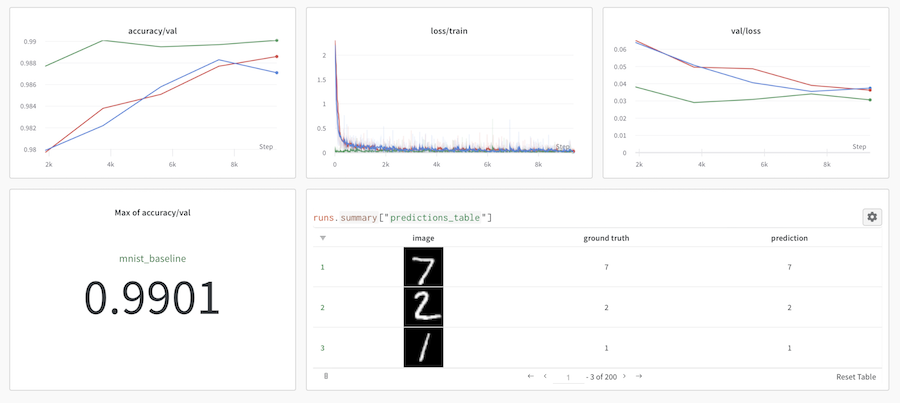

## 📚 Resources

* We are excited to showcase this early support of [MosaicML-Composer](https://docs.mosaicml.com/en/latest/index.html) go ahead and try this new state of the art framework.

## ❓ Questions about W&B

If you have any questions about using W&B to track your model performance and predictions, please reach out to the [slack community](http://bit.ly/wandb-forum).